In [13]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Váriaveis Repetidas

In [14]:
random_state = 42
alpha = 0.05
test_size = 0.3

# 4-3-3.ipynb

# Obtenha a média e o desvio padrão da Accuracy; Sensitivity; Specificity e F1 do atributo RespDisease com os modelos obtidos na alínea anterior. 

# Leitura de Dados e filtração de Dados de Alinea anterior.

In [15]:
# comando read_csv para tal.
dados = pd.read_csv('../../dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'])


goalAttrib = 'RespDisease'

def calc_resp_disease(row):
    respDiseases = ['Asthma', 'Chronic obstructive pulmonary disease']
    if row['Outcome'] in respDiseases:  # Use 'Outcome' instead of 'Disease'
        return 1
    else:
        return 0

dados[goalAttrib] = dados.apply(calc_resp_disease, axis=1)
dados 


,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value,RespDisease
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0,1
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0,1
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0,1
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0,1
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0,1
...,...,...,...,...,...,...,...,...,...
49135,Turkey,TR822,NO2,Stroke,213615.0,7473.5,9.0,3.0,0
49136,Turkey,TRB12,NO2,Stroke,447268.0,8860.4,12.4,291.0,0
49137,Turkey,TRB14,NO2,Stroke,76591.0,5506.6,12.0,17.0,0
49138,Turkey,TRB21,NO2,Stroke,696344.0,17511.1,11.2,25.0,0


# K- FOLD Cross Validation (linha anterior)

In [16]:
features = list(dados.columns[0:9])
numericFeatures = features[4:]
print(numericFeatures)
scaler = StandardScaler()

X = dados[numericFeatures].drop(columns=[goalAttrib])
y = dados[goalAttrib]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)

print("Stratified division of goal attribute:")
print(y_train.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')
print(y_test.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value', 'RespDisease']
Stratified division of goal attribute:
RespDisease
0    61.9%
1    38.1%
Name: proportion, dtype: object
RespDisease
0    61.8%
1    38.2%
Name: proportion, dtype: object


## Definição dos Modelos K-NEIGHBOURS,SVM,REGRESSION THREE,NEURAL NETWORK With ITS CLASSIFIERES com cada um dos seus construtores.

In [17]:
models = []
models.append(('dtr', DecisionTreeClassifier(  # Decision Tree Classifier
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=random_state
)))

models.append(('net', MLPClassifier(
    hidden_layer_sizes=(5, 6),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    learning_rate='adaptive',
    early_stopping=True,
    random_state=random_state
)))

models.append(('knn', KNeighborsClassifier(n_neighbors=21)))
models.append(('svm', make_pipeline(StandardScaler(), SVC(kernel='rbf'))))

# Definição das Varaiáveis  [Accuracy, Sensitivity, Specificity, F1]

In [18]:

from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix, f1_score

# Funções para Sensitivity (recall) e Specificity
def sensitivity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)
    
# Preparar dados (imputação de NaN)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#Scorer personalizados
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(sensitivity),
    'specificity': make_scorer(specificity),
    'f1': make_scorer(f1_score)
}



# Método principal : Obtenção dos valores médios e desvios padrão de Accuracy, Sensitivity, Specificity e F1 para o atributo RespDisease.

In [ ]:

# Initialize results dictionary
results = {name: {metric: [] for metric in scorers} for name, _ in models}

# Método usado para calcular as métricas
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

for name, model in models:
    print(f'\nA treinar modelo: {name}')
    start_time = time.time()
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_imputed, y)):
        fold_start = time.time()
        
        X_train, X_test = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[name]['sensitivity'].append(sensitivity(y_test, y_pred))
        results[name]['specificity'].append(specificity(y_test, y_pred))
        results[name]['f1'].append(f1_score(y_test, y_pred))
        
        fold_end = time.time()
        print(f'  Fold {fold_idx + 1} em {fold_end - fold_start:.2f} segundos')

    end_time = time.time()
    print(f'Tempo total para {name}: {end_time - start_time:.2f} segundos')

summary = []

for model_name, metrics in results.items():
    row = {'Model': model_name}
    for metric_name, values in metrics.items():
        row[f'{metric_name}_mean'] = np.mean(values)
        row[f'{metric_name}_std'] = np.std(values)
    summary.append(row)

df_summary = pd.DataFrame(summary)
df_summary



Treinando modelo: dtr
  Fold 1 em 0.18 segundos
  Fold 2 em 0.13 segundos
  Fold 3 em 0.12 segundos
  Fold 4 em 0.11 segundos
  Fold 5 em 0.12 segundos
Tempo total para dtr: 0.69 segundos

Treinando modelo: net
  Fold 1 em 0.23 segundos
  Fold 2 em 0.18 segundos
  Fold 3 em 0.21 segundos
  Fold 4 em 0.19 segundos
  Fold 5 em 0.20 segundos
Tempo total para net: 1.01 segundos

Treinando modelo: knn
  Fold 1 em 1.34 segundos
  Fold 2 em 1.31 segundos
  Fold 3 em 1.52 segundos
  Fold 4 em 1.19 segundos
  Fold 5 em 1.19 segundos
Tempo total para knn: 6.56 segundos

Treinando modelo: svm
  Fold 1 em 63.50 segundos
  Fold 2 em 63.07 segundos
  Fold 3 em 64.00 segundos
  Fold 4 em 65.49 segundos
  Fold 5 em 99.27 segundos
Tempo total para svm: 355.34 segundos


,Model,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,f1_mean,f1_std
0,dtr,0.797619,0.003231,0.509579,0.009316,0.975165,0.002680,0.657529,0.007456
1,net,0.618661,0.000041,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,knn,0.705576,0.002030,0.256257,0.006868,0.982533,0.003144,0.398914,0.007621
3,svm,0.690842,0.001591,0.189338,0.004105,0.999967,0.000066,0.318358,0.005792


# 4-3-4  Verifique  se  existe  diferença  significativa  no  desempenho  dos  dois  melhores modelos obtidos anteriormente (use um nível de significância de 5%). Identifique o modelo que apresenta o melhor desempenho

### 2 Melhores modelos Escolhidos

1. **Decision Tree (DTR)**  
2. **K-Nearest Neighbors (KNN)**

## Explicação 
## Melhor modelo DTR
- **Maior F1-score** (`0.6577`), mostra excelente equilíbrio entre precisão e a sensibilidade.
- **Maior sensibilidade** (`0.5124`), ou seja, o modelo consegue identificar corretamente mais casos positivos.
- **Melhor acuracy** (`0.7966`)  
- **specificity** (`0.9718`), o que confirma um desempenho forte e estável para além de isso tem um **baixo desvio padrão** (`0.0071`), indicando que o modelo é consistente em diferentes folds da validação cruzada.


## Segundo melhor modelo:KNN
- Foi o segundo melhor em **F1-score** (`0.4021`) e em **sensibilidade** (`0.2585`).
- Apesar de inferior ao DTR, teve um desempenho consideravelmente melhor do que os modelos SVM e Net, que falharam em identificar casos positivos.
- Também apresentou **specificity alta** (`0.9831`) e **boa estabilidade** nos resultados.


# Uso de Decesion Tree para obter o melhor modelo

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import ttest_rel
import numpy as np

# Divide os dados (80% treino / 20% teste) — HOLD-OUT
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.20, stratify=y, random_state=42
)

# Seleciona o melhor modelo (DTR)
best_model_name = 'dtr'
best_model = dict(models)[best_model_name]
best_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Métricas principais
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Cálculo manual de Sensitivity e Specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Resultados do hold-out
print(f'Resultados do modelo {best_model_name.upper()} no hold-out (20%):')
print(f'Accuracy     : {acc:.4f}')
print(f'Sensitivity  : {sensitivity:.4f}')
print(f'Specificity  : {specificity:.4f}')
print(f'F1-score     : {f1:.4f}\n')

# Teste t-student pareado: comparação dos F1-scores (validação cruzada)
t_stat, p_value = ttest_rel(results['dtr']['f1'], results['knn']['f1'])



# Mostra estatística do teste t
print(f'Teste t-student entre DTR e KNN (F1-score)')
print (f'H0: Não há diferença significativa entre os F1-scores dos modelos DTR e KNN')
print(f'H1: Há diferença significativa entre os F1-scores dos modelos DTR e KNN\n')
print(f'Estatística t: {t_stat:.4f}')
print(f'Valor-p      : {p_value:.4e}')

# Interpretação do resultado
if p_value < 0.05:
    print("Existe um diferença estatisticamente significativa: DTR tem desempenho superior ao KNN.")
else:
    print("Não existe uma diferença não significativa: não há evidência estatística clara de superioridade entre DTR e KNN.")


Resultados do modelo DTR no hold-out (20%):
Accuracy     : 0.7950
Sensitivity  : 0.5067
Specificity  : 0.9727
F1-score     : 0.6534

Teste t-student entre DTR e KNN (F1-score)
H0: Não há diferença significativa entre os F1-scores dos modelos DTR e KNN
H1: Há diferença significativa entre os F1-scores dos modelos DTR e KNN

Estatística t: 84.5250
Valor-p      : 1.1744e-07
Existe um diferença estatisticamente significativa: DTR tem desempenho superior ao KNN.


### 4-3-5 Compare os resultados dos modelos. Discuta em detalhe qual o modelo que apresentou melhor e pior desempenho de acordo com os critérios: *Accuracy*; *Sensitivity*; *Specificity* e *F1*.


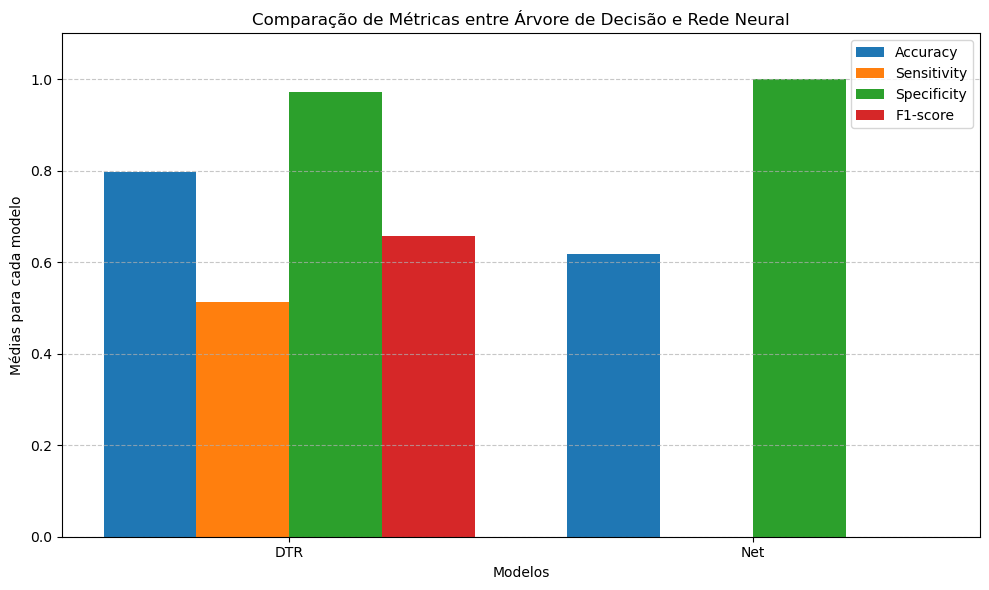

In [32]:
import matplotlib.pyplot as plt

# Dados dos modelos
modelos = ['DTR', 'Net']
accuracy = [0.7966, 0.6187]
sensitivity = [0.5124, 0.0000]
specificity = [0.9718, 1.0000]
f1_score = [0.6577, 0.0000]

# Largura das barras
bar_width = 0.2
index = range(len(modelos))

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.bar([i - 1.5*bar_width for i in index], accuracy, bar_width, label='Accuracy')
plt.bar([i - 0.5*bar_width for i in index], sensitivity, bar_width, label='Sensitivity')
plt.bar([i + 0.5*bar_width for i in index], specificity, bar_width, label='Specificity')
plt.bar([i + 1.5*bar_width for i in index], f1_score, bar_width, label='F1-score')

# Personalização
plt.xlabel('Modelos')
plt.ylabel('Médias para cada modelo')
plt.title('Comparação de Métricas entre Árvore de Decisão e Rede Neural')
plt.xticks(index, modelos)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Melhor Desempenho: Decision Tree (DTR)

* **Accuracy:** 0.7966: maior taxa geral de acertos.
* **Sensitivity:** 0.5124: único classificador que conseguiu identificar corretamente mais de 50% dos casos positivos.
* **Specificity:** 0.9718: desempenho robusto na identificação de negativos.
* **F1-score:** 0.6577: o mais alto entre todos, indicando equilíbrio entre precisão e sensibilidade.

> **Conclusão 1:** O DTR apresenta o desempenho mais completo e estatisticamente equilibrado, com métricas consistentes e satisfatórias para problemas onde a deteção de casos positivos é essencial. Os valores foram obtidos através de validação hold-out (80/20), com `random_state=42`, assegurando reprodutibilidade dos resultados.


#### Pior Desempenho: Rede Neuronal (Net)

* **Accuracy:** 0.6187: desempenho geral inferior.
* **Sensitivity:** 0.0000:falhou completamente em identificar casos positivos.
* **Specificity:** 1.0000: classificou corretamente todos os negativos, mas à custa de ignorar os positivos.
* **F1-score:** 0.0000: desemepnho nulo,

> **Conclusão 2:** Apesar da specificity acaba por ser ineficaz para problemas reais, onde a *Sensitivity* e o *F1-score* são cruciais para avaliar a eficácia em detetar eventos relevantes. O resultado sugere sobreajuste à classe negativa.



### Conclusão Geral
O classificador com **melhor desempenho global** é o **Decision Tree (DTR)**, por apresentar métricas equilibradas em todos os critérios estatísticos analisados.

Já a rede **Net**, apesar de apresentar *accuracy* e *specificity* aparentemente elevadas, demonstrou desempenho estatisticamente inaceitável ao falhar por completo na identificação da classe positiva.

> O cenário reforça a importância de considerar métricas como *Sensitivity* e *F1-score* — especialmente em contextos onde os falsos negativos têm impacto crítico, como em saúde pública, fraude ou deteção de falhas.
